In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [37]:
def generate_fishing_grounds(n_grounds = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_grounds, 2) * np.array([x_max, y_max])

In [38]:
def generate_ships(n_ships = 10, x_max = 100, y_max = 100):
    return np.random.rand(n_ships, 2) * np.array([x_max, y_max])

In [39]:
grounds = generate_fishing_grounds()
ships = generate_ships(20)

In [40]:
def calculate_ship_distance_from_grounds(ships, grounds):
    return np.linalg.norm(ships[:, np.newaxis] - grounds, axis=2)

In [41]:
def d_unit_vectors(ships, grounds):
    differences = grounds - ships[:, np.newaxis]
    distances = np.linalg.norm(differences, axis=2)
    return differences / distances[:, :, np.newaxis]

In [42]:
def ship_ground_gaussians(ships, grounds, alpha):
    return np.exp(-alpha * calculate_ship_distance_from_grounds(ships, grounds)**2)

In [43]:
def calculate_ship_distance_from_ships(ships):
    return np.linalg.norm(ships[:, np.newaxis] - ships, axis=2)

In [44]:
def harbor_attraction(U, ships, h):
    # Calculate the difference vector
    diff = h - ships

    # normalize the difference vector
    diff /= np.linalg.norm(diff, axis=1)[:, np.newaxis]

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-2].reshape(-1, 1)

    return U_reshaped * diff

In [45]:
def attraction_matrix(U, G, D, F):
    return U[:,:-2] * G * D * F

In [46]:
def calculate_F_prime(t, F, G, rate):

    # Take the sum of the ship_ground_gaussians over all ships for each ground
    G_sum = np.sum(G, axis=0)

    # Calculate F_prime as -rate * F * g_sum
    F_prime = -rate * F * G_sum

    return F_prime

In [57]:
def calculate_x_prime(t, x, F, A, U, H):
    # sum the attraction matrix over all grounds and harbor
    A_sum = np.sum(A, axis=1).reshape(-1, 1) + H

    print(A_sum.shape)

    # normalize the sum
    A_sum /= np.linalg.norm(A_sum)

    # Reshape U[:,-2] to have an extra dimension
    U_reshaped = U[:,-1].reshape(-1, 1)

    return U_reshaped * A_sum

In [58]:
def ode(t, y, params):
    alpha, rate, U, grounds, h, x_size, F_size, x_shape = params
    x = y[:x_size].reshape(x_shape)  # reshape x back to its original shape
    F = y[x_size:x_size+F_size]

    # Calculate G matrix
    G = ship_ground_gaussians(x, grounds, alpha)

    # Calculate D matrix
    D = calculate_ship_distance_from_grounds(x, grounds)

    # Calculate A matrix
    A = attraction_matrix(U, G, D, F)

    # Calculate H
    H = harbor_attraction(U, x, h)

    # Calculate F' (you'll need to replace this with your actual calculation)
    F_prime = calculate_F_prime(t, F, G, rate)

    # Calculate x' (you'll need to replace this with your actual calculation)
    x_prime = calculate_x_prime(t, x, F, A, U, H)

    # Flatten x_prime and F_prime and concatenate them into a single 1D array
    return np.concatenate((x_prime.flatten(), F_prime.flatten()))

In [65]:
alpha = .002
rate = .001

# initialize U as all ones
U = np.ones((ships.shape[0], grounds.shape[0] + 2))

# initialize F as all ones
F = np.ones(grounds.shape[0])

# x is ship positions
x = ships

# h is the harbor position
h = np.array([0, 50])

# Get the sizes of x and F before flattening
x_size = np.prod(x.shape)
F_size = np.prod(F.shape)

# Get the original shape of x
x_shape = x.shape

# Flatten x and F into a single 1D array
y0 = np.concatenate((x.flatten(), F))

params = (alpha, rate, U, grounds, h, x_size, F_size, x_shape)


sol = solve_ivp(ode, [0, 100], y0, args=(params,), t_eval=np.linspace(0, 100, 1000))


(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


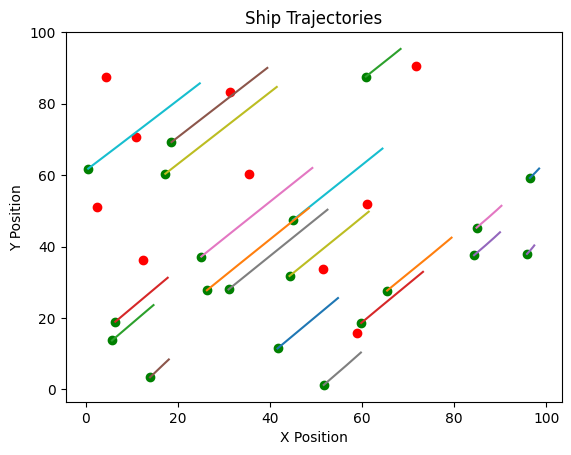

In [66]:
import matplotlib.pyplot as plt

# Extract ship positions from the solution
ship_positions = sol.y[:x_size].reshape(x_shape + (-1,))

# Plot the grounds
plt.scatter(grounds[:, 0], grounds[:, 1], c='red', label='Grounds')

# Plot the starting points of the ships
plt.scatter(ship_positions[:, 0, 0], ship_positions[:, 1, 0], c='green', label='Starting points')

# Plot the trajectory of each ship
for i in range(ship_positions.shape[0]):
    plt.plot(ship_positions[i, 0, :], ship_positions[i, 1, :], label=f'Ship {i+1}')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Ship Trajectories')
plt.show()

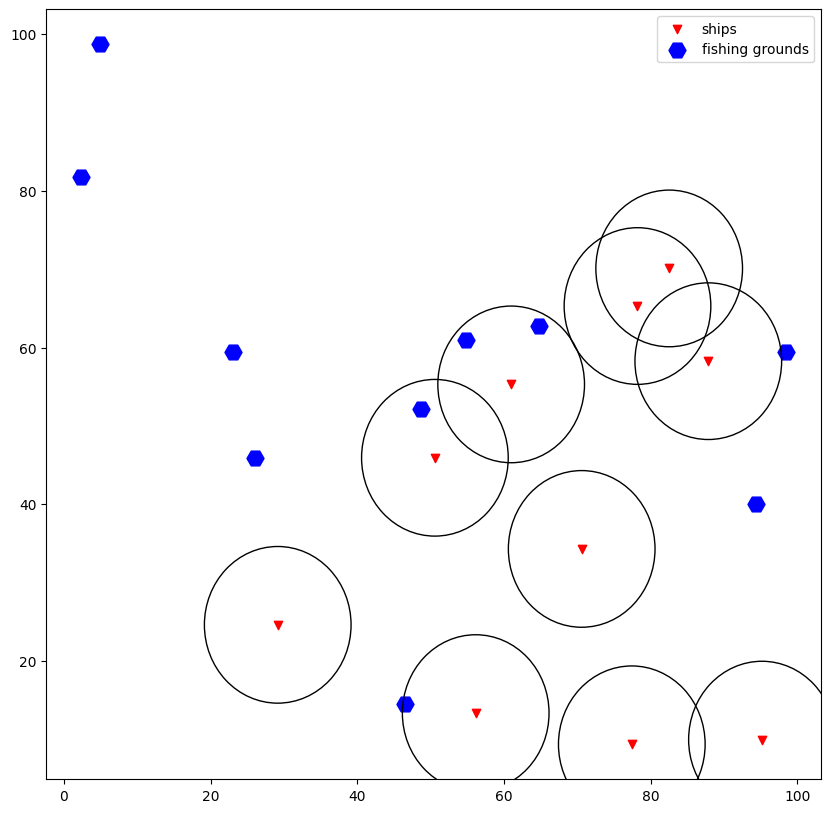

In [10]:
plt.figure(figsize=(10, 10))
# plot the ships and the fishing grounds
plt.scatter(ships[:, 0], ships[:, 1], c='red', label='ships', marker='v')
plt.scatter(grounds[:, 0], grounds[:, 1], c='blue', label='fishing grounds', marker='H', s=150)

# add a circle around the ships with a given radius
radius = 10
for ship in ships:
    plt.gca().add_artist(plt.Circle(ship, radius, fill=False))


plt.legend()
plt.show()